# Time Series - Example Part 1
This notebook is a simple walkthrough of a Time Series dataset for the temperatures in Toronto, Canada. We will be using Facebook's Prophet in Part 1 as well as creating a simple Neural Network using a GRU layer in Part 2. For more information regarding Facebook's Prophet Module please view the notebook *Time Series with Prophet* under the Prophet folder in the repo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from prophet import Prophet as proph

Importing plotly failed. Interactive plots will not work.


## Exploratory Data Analysis & Feature Engineering

In [3]:
toronto = pd.read_csv('../data/toronto_temp.csv')

In [4]:
toronto.head()

,Date/Time,Year,Month,Day,Mean Temp (C),Max Temp (C),Min Temp (C),Total Rain (mm),Total Snow (cm),Total Precip (mm),season
0,31-Jan-18,"2,018",1,31,-7.0,2.0,-15.0,0.0,1.0,1.0,Winter
1,30-Jan-18,"2,018",1,30,-11.0,-7.0,-15.0,0.0,0.0,0.0,Winter
2,29-Jan-18,"2,018",1,29,-4.0,-2.0,-7.0,0.0,5.0,5.0,Winter
3,28-Jan-18,"2,018",1,28,1.0,5.0,-3.0,0.0,0.0,0.0,Winter
4,27-Jan-18,"2,018",1,27,5.0,10.0,0.0,2.0,0.0,2.0,Winter


In [5]:
toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date/Time          2889 non-null   object 
 1   Year               2889 non-null   object 
 2   Month              2889 non-null   int64  
 3   Day                2889 non-null   int64  
 4   Mean Temp (C)      2876 non-null   float64
 5   Max Temp (C)       2877 non-null   float64
 6   Min Temp (C)       2877 non-null   float64
 7   Total Rain (mm)    2863 non-null   float64
 8   Total Snow (cm)    2871 non-null   float64
 9   Total Precip (mm)  2865 non-null   float64
 10  season             2889 non-null   object 
dtypes: float64(6), int64(2), object(3)
memory usage: 248.4+ KB


In [6]:
toronto['Year'] = toronto['Year'].replace({',': ''}, regex=True)
toronto['Year'] = pd.to_numeric(toronto['Year'])
toronto['Year'].dtype

dtype('int64')

In [7]:
print(f'Toronto Max Year {toronto.Year.max()}')
print(f'Toronto Min Year {toronto.Year.min()}')

Toronto Max Year 2018
Toronto Min Year 1937


In [8]:
toronto[toronto['Year']==1937]

,Date/Time,Year,Month,Day,Mean Temp (C),Max Temp (C),Min Temp (C),Total Rain (mm),Total Snow (cm),Total Precip (mm),season
2657,01-Nov-37,1937,11,1,3.3,8.0,-1.4,33.8,0.0,33.8,Fall
2888,01-Dec-37,1937,12,1,-4.4,0.1,-8.8,7.6,33.8,41.4,Winter


In [9]:
toronto[toronto['Year']==2018].head()

,Date/Time,Year,Month,Day,Mean Temp (C),Max Temp (C),Min Temp (C),Total Rain (mm),Total Snow (cm),Total Precip (mm),season
0,31-Jan-18,2018,1,31,-7.0,2.0,-15.0,0.0,1.0,1.0,Winter
1,30-Jan-18,2018,1,30,-11.0,-7.0,-15.0,0.0,0.0,0.0,Winter
2,29-Jan-18,2018,1,29,-4.0,-2.0,-7.0,0.0,5.0,5.0,Winter
3,28-Jan-18,2018,1,28,1.0,5.0,-3.0,0.0,0.0,0.0,Winter
4,27-Jan-18,2018,1,27,5.0,10.0,0.0,2.0,0.0,2.0,Winter


In [10]:
toronto['Mean Temp (C)'].isnull().sum()

13

In [11]:
datetime=['Year','Month','Day'] 
toronto['ds'] = toronto[datetime].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)
toronto.ds = pd.to_datetime(toronto.ds)
toronto.head()

,Date/Time,Year,Month,Day,Mean Temp (C),Max Temp (C),Min Temp (C),Total Rain (mm),Total Snow (cm),Total Precip (mm),season,ds
0,31-Jan-18,2018,1,31,-7.0,2.0,-15.0,0.0,1.0,1.0,Winter,2018-01-31
1,30-Jan-18,2018,1,30,-11.0,-7.0,-15.0,0.0,0.0,0.0,Winter,2018-01-30
2,29-Jan-18,2018,1,29,-4.0,-2.0,-7.0,0.0,5.0,5.0,Winter,2018-01-29
3,28-Jan-18,2018,1,28,1.0,5.0,-3.0,0.0,0.0,0.0,Winter,2018-01-28
4,27-Jan-18,2018,1,27,5.0,10.0,0.0,2.0,0.0,2.0,Winter,2018-01-27


In [12]:
toronto.ds.dtype

dtype('<M8[ns]')

In [13]:
toronto.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Mean Temp (C)', 'Max Temp (C)',
       'Min Temp (C)', 'Total Rain (mm)', 'Total Snow (cm)',
       'Total Precip (mm)', 'season', 'ds'],
      dtype='object')

In [14]:
drop_cols = ['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (C)','Min Temp (C)', 
             'Total Rain (mm)', 'Total Snow (cm)','Total Precip (mm)', 'season']
toronto_proph = toronto.drop(columns=drop_cols)
toronto_proph = toronto_proph.rename(columns={'Mean Temp (C)':'y'})
toronto_proph.columns

Index(['y', 'ds'], dtype='object')

In [15]:
#dti version for datetime index with resample on Months
toronto_proph_dti = toronto_proph.resample('MS', on='ds',origin='epoch').mean() #Use 'MS' for Month Start
toronto_proph_dti.head()

,y
ds,
1937-11-01,3.3
1937-12-01,-4.4
1938-01-01,-7.2
1938-02-01,-3.7
1938-03-01,1.4


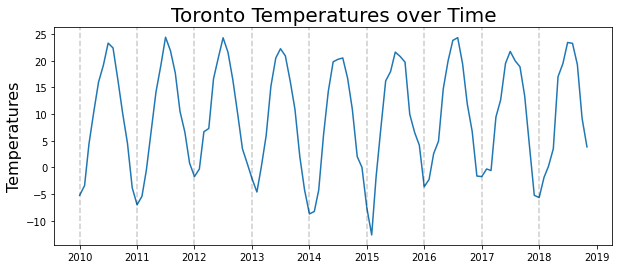

In [16]:
plt.figure(figsize=(10,4))
plt.plot(toronto_proph_dti.loc['2010-01':].y)
plt.title('Toronto Temperatures over Time', fontsize=20)
plt.ylabel('Temperatures', fontsize=16)
for year in range(2010,2019):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

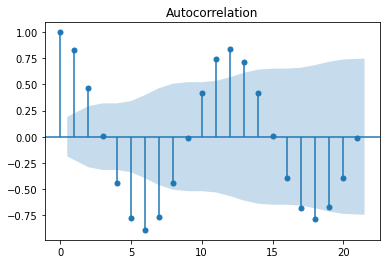

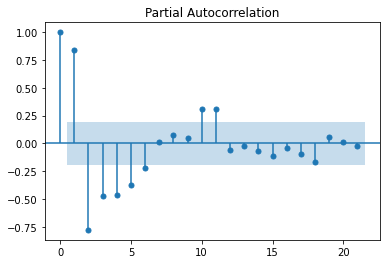

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(toronto_proph_dti.loc['2010-01':].y)
plt.show()

plot_pacf(toronto_proph_dti.loc['2010-01':].y)
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    results = adfuller(series)
    print(f'ADF Statistic: {results[0]}')
    print(f'P-Value: {results[1]}')
    
adf_test(toronto_proph_dti.loc['2010-01':])

ADF Statistic: -1.729773717163336
P-Value: 0.4158411123329355


# Train & Test Sets

In [19]:
#dataframe version for prophet
toronto_proph = toronto_proph_dti.loc['2010-01':].reset_index()

In [20]:
train_toronto = toronto_proph[:-11]
test_toronto = toronto_proph[-11:]

# Prophet Model

In [21]:
interval=0.95

m = proph(interval_width=interval)
m.fit(train_toronto)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future = m.make_future_dataframe(periods=11,freq='MS')
future.tail()

,ds
102,2018-07-01
103,2018-08-01
104,2018-09-01
105,2018-10-01
106,2018-11-01


In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
102,2018-07-01,22.891768,18.786477,26.883231
103,2018-08-01,21.650007,17.632480,25.479924
104,2018-09-01,17.966589,13.930441,22.195511
105,2018-10-01,10.946363,6.885078,14.813092
106,2018-11-01,4.835117,0.905151,8.753547


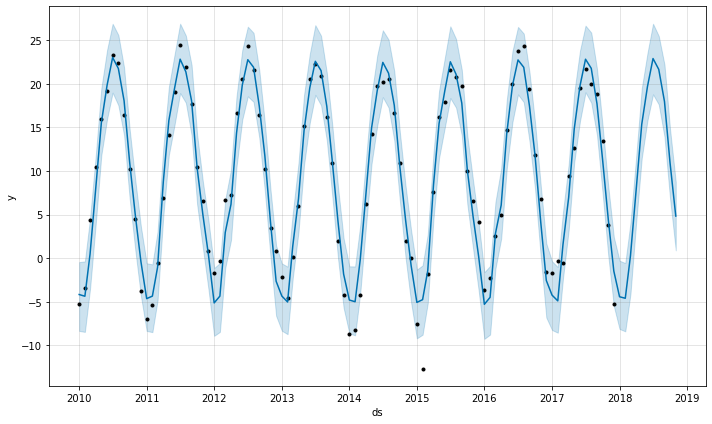

In [24]:
fig1 = m.plot(forecast)

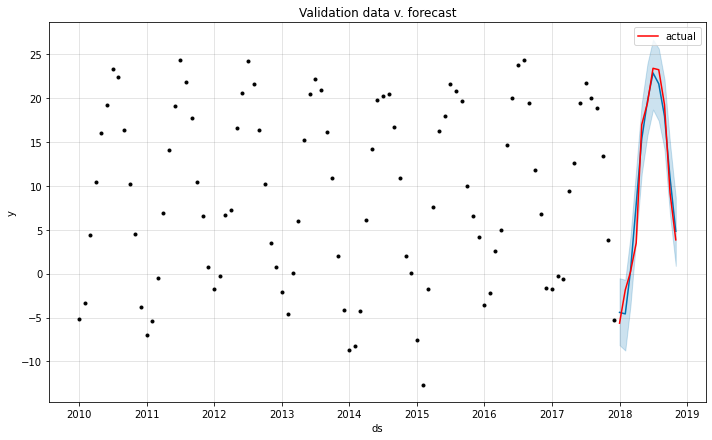

In [25]:
y_pred = m.predict(test_toronto)
m.plot(y_pred, uncertainty=True)
plt.plot(test_toronto.ds[-11:], test_toronto.y[-11:], color='r', label='actual')
plt.title('Validation data v. forecast')
plt.legend()

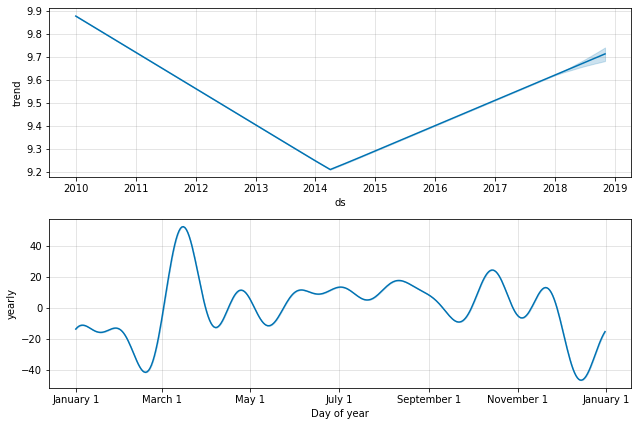

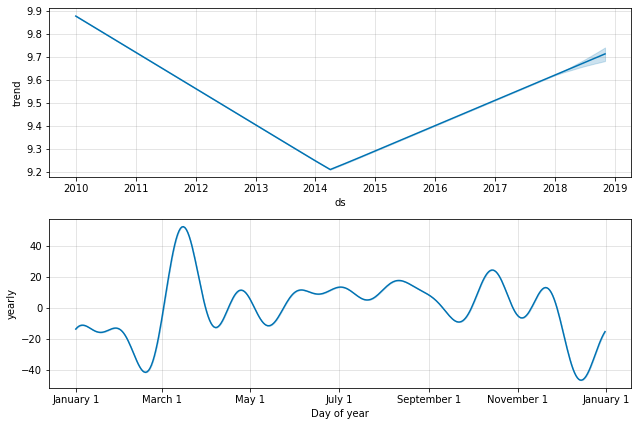

In [26]:
m.plot_components(forecast)

# Evaluation Metrics

In [27]:
predictions = y_pred['yhat']
y_test = test_toronto['y']
y_test = y_test.reset_index(drop=True) # resetting index due to calculation issues

In [28]:
from sklearn import metrics
import numpy as np

MAE = metrics.mean_absolute_error(y_test,predictions)
MAPE = metrics.mean_absolute_percentage_error(y_test,predictions) * 100
MSE = metrics.mean_squared_error(y_test,predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions))
MedAE = metrics.median_absolute_error(y_test,predictions)
MedAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100

In [29]:
print('MAE:', np.round(MAE,2))
print('MAPE:', np.round(MAPE,2),'%')
print('MSE:', np.round(MSE,2))
print('RMSE:', np.round(RMSE,2))
print('MedAE:', np.round(MedAE,2))
print('MedAPE:',np.round(MedAPE,2),'%')

MAE: 1.5
MAPE: 37.3 %
MSE: 3.61
RMSE: 1.9
MedAE: 1.31
MedAPE: 18.98 %


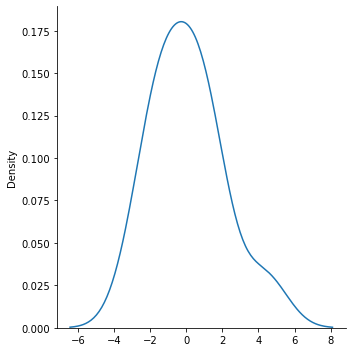

In [30]:
import seaborn as sns
residuals = predictions - y_test
sns.displot(data=residuals,kind='kde')

# Analyzing the Results
Overall the Prophet model does a good job predicting future temperatures given nothing else but historical data on past temperatures. Our metrics seem to indicate that the model is a good performer with a residual plot exhibiting a normal distribution (which is what we're looking for to confirm a good fit). The Percentage errors seem to indicate that there is a noticeable difference between the predictions and the actual temperatures. By looking at our RMSE and MAE we can see that generally our predictions seem to be about 1.5°C to 2.0°C off the actual temperature (equating to about 2.5°F to 3.5°F off of the actual temperatures). Considering that these predictions are being made soley off of historical data these predictions are not too far off from the actual temperatures. 

In [31]:
toronto_preprocessed = toronto_proph_dti.reset_index()
toronto_preprocessed.head()

,ds,y
0,1937-11-01,3.3
1,1937-12-01,-4.4
2,1938-01-01,-7.2
3,1938-02-01,-3.7
4,1938-03-01,1.4


In [32]:
#toronto_preprocessed.to_csv('..data/toronto_preprocessed.csv',index=False)